In [1]:
from pathlib import Path
from scipy.stats import lognorm
from numpy import exp

from fediverse_analysis.instance_data.analyze import Analyzer

In [2]:
INSTANCE_DATA_PATH = Path('/mnt/ceph/storage/data-in-progress/data-teaching/theses/wstud-thesis-ernst/instance-data/mastodon')
SAMPLE_OUTPUT_FILE_NAME = 'sampled_instances'
SAMPLE_OUTPUT_FILE_EXT = 'txt'
COLUMNS = [Analyzer.TOTAL_USERS, Analyzer.MONTHLY_USERS, Analyzer.TOTAL_STATUSES,
        Analyzer.WEEKLY_STATUSES, Analyzer.WEEKLY_LOGINS, Analyzer.WEEKLY_REGS]
NUM_SAMPLES = 1000

In [3]:
cols_prob_measures = {
    col: lognorm
    for col in COLUMNS
}
with open(INSTANCE_DATA_PATH, 'r') as file:
    an = Analyzer(file)

Total number of instances: 22052
Removed for (partially) no data: 12424
Remaining: 9628


In [4]:
df = an.df
df

,total_users,monthly_users,total_statuses,weekly_statuses,weekly_logins,weekly_registrations
instance,,,,,,
0371.uk,1,1,112,1.00,6.25,0.00
0x3c.pl,91,10,2305,6.00,1.50,0.25
0x4655.co.uk,1,0,0,0.00,0.00,0.00
0x50.ch,1,0,2,0.00,0.00,0.00
0xee.io,16,3,199,1.25,1.00,0.00
...,...,...,...,...,...,...
zusammenhalt.de,1,1,36,1.00,7.00,0.00
zusammenkunft.net,2,2,5110,2.00,62.00,0.00
zweibruecken.social,3,2,495,1.25,2.50,0.00


array([[<Axes: title={'center': 'total_users'}>,
        <Axes: title={'center': 'monthly_users'}>],
       [<Axes: title={'center': 'total_statuses'}>,
        <Axes: title={'center': 'weekly_statuses'}>],
       [<Axes: title={'center': 'weekly_logins'}>,
        <Axes: title={'center': 'weekly_registrations'}>]], dtype=object)

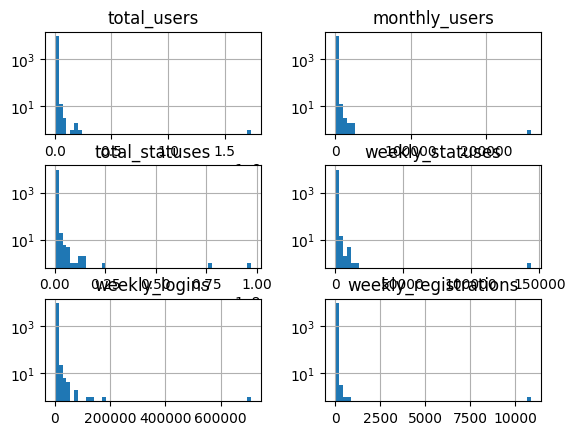

In [5]:
df[cols_prob_measures.keys()].hist(log=True, bins=50)

In [6]:
# Estimate probability distributions over activity columns
distributions = {
    col: dist.fit(df[col])
    for col, dist in cols_prob_measures.items()
}
distributions

/home/tschaeggaer/Projekte/thesis-ernst/code/venv/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6120: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/home/tschaeggaer/Projekte/thesis-ernst/code/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/tschaeggaer/Projekte/thesis-ernst/code/venv/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


{'total_users': (2.0370605170730993, -0.004859465990659663, 6.102090179289142),
 'monthly_users': (220.26123291478217, -5e-324, 1.6987864906320246e-31),
 'total_statuses': (1.419863860849846,
  -1301.9231899742335,
  3121.9460086690183),
 'weekly_statuses': (225.67500767238406, -5e-324, 2.183561344276233e-33),
 'weekly_logins': (349.31317034657786, -5e-324, 2.3128288775016932e-104),
 'weekly_registrations': (261.30076972606366, -5e-324, 1.697499084401145e-277)}

In [7]:
# Compute normalize activity score by dividing by the estimated probability.
for col, dist in cols_prob_measures.items():
    shape, location, scale = distributions[col]
    df[f"{col}_log_probability"] = dist.logpdf(df[col], shape, location, scale)

# Compute joint probability (under assumption of independence; using log probabilities for numerical stability)
df["log_probability"] = 0
for col in cols_prob_measures.keys():
    df["log_probability"] += df[f"{col}_log_probability"]

df.sort_values("log_probability", inplace=True)
df

,total_users,monthly_users,total_statuses,weekly_statuses,weekly_logins,weekly_registrations,total_users_log_probability,monthly_users_log_probability,total_statuses_log_probability,weekly_statuses_log_probability,weekly_logins_log_probability,weekly_registrations_log_probability,log_probability
instance,,,,,,,,,,,,,
mastodon.social,1731177,259375,76561255,143939.75,708696.75,10872.75,-34.989906,-18.851324,-44.760171,-18.289633,-20.506520,-18.840127,-156.237680
mstdn.social,219348,24598,14341831,14823.75,120733.75,438.00,-27.187385,-16.491726,-35.384136,-16.012633,-18.733037,-15.597991,-129.406907
mastodon.online,194387,21545,7290115,12989.00,84165.25,721.25,-26.762945,-16.358983,-31.991124,-15.880285,-18.371491,-16.101460,-125.466288
mas.to,167800,18617,6609680,11433.50,78591.00,212.50,-26.250957,-16.212672,-31.518645,-15.752518,-18.302826,-14.867903,-122.905520
mastodon.world,181076,20121,4547385,10787.25,49559.75,362.50,-26.515368,-16.290490,-29.759150,-15.694239,-17.840804,-15.407014,-121.507065
...,...,...,...,...,...,...,...,...,...,...,...,...,...
mastodon.alex.net,1,0,0,0.00,0.00,0.00,-2.027335,733.450207,-8.630816,733.704988,736.616795,737.871380,2930.985220
mastodon.aftbit.com,1,0,0,0.00,0.00,0.00,-2.027335,733.450207,-8.630816,733.704988,736.616795,737.871380,2930.985220
mastodon.aargaunet.ch,1,0,0,0.00,0.00,0.00,-2.027335,733.450207,-8.630816,733.704988,736.616795,737.871380,2930.985220


In [8]:
df["weight"] = exp(-df["log_probability"])
df_sample = df.sample(n=NUM_SAMPLES, replace=False, weights=df["weight"])
df_sample

,total_users,monthly_users,total_statuses,weekly_statuses,weekly_logins,weekly_registrations,total_users_log_probability,monthly_users_log_probability,total_statuses_log_probability,weekly_statuses_log_probability,weekly_logins_log_probability,weekly_registrations_log_probability,log_probability,weight
instance,,,,,,,,,,,,,,
mastodon.social,1731177,259375,76561255,143939.75,708696.75,10872.75,-34.989906,-18.851324,-44.760171,-18.289633,-20.506520,-18.840127,-156.237680,7.131197e+67
mstdn.social,219348,24598,14341831,14823.75,120733.75,438.00,-27.187385,-16.491726,-35.384136,-16.012633,-18.733037,-15.597991,-129.406907,1.587471e+56
mastodon.online,194387,21545,7290115,12989.00,84165.25,721.25,-26.762945,-16.358983,-31.991124,-15.880285,-18.371491,-16.101460,-125.466288,3.085435e+54
mas.to,167800,18617,6609680,11433.50,78591.00,212.50,-26.250957,-16.212672,-31.518645,-15.752518,-18.302826,-14.867903,-122.905520,2.383358e+53
mastodon.world,181076,20121,4547385,10787.25,49559.75,362.50,-26.515368,-16.290490,-29.759150,-15.694239,-17.840804,-15.407014,-121.507065,5.886375e+52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mastodon.aridgwayweb.com,2,2,893,1.75,199.00,0.25,-2.475299,-7.059651,-8.994186,-6.954005,-12.312020,-8.059512,-45.854673,8.211670e+19
ivory.rosebloom.one,37,14,23502,5.50,0.25,0.25,-5.632943,-9.008470,-12.453588,-8.100853,-5.619251,-8.059512,-48.874617,1.682583e+21
biplus.social,34,9,2018,7.25,28.50,0.25,-5.512535,-8.565970,-9.378134,-8.377525,-10.364750,-8.059512,-50.258426,6.713625e+21


array([[<Axes: title={'center': 'total_users'}>,
        <Axes: title={'center': 'monthly_users'}>],
       [<Axes: title={'center': 'total_statuses'}>,
        <Axes: title={'center': 'weekly_statuses'}>],
       [<Axes: title={'center': 'weekly_logins'}>,
        <Axes: title={'center': 'weekly_registrations'}>]], dtype=object)

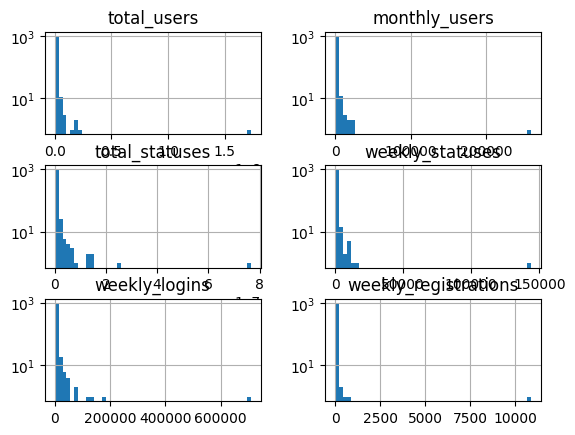

In [9]:
df_sample[cols_prob_measures.keys()].hist(log=True, bins=50)

In [10]:
df_sample.sort_index(inplace=True)
# Full DataFrame. Maybe we want to have that data later.
df_sample.to_csv(Path(SAMPLE_OUTPUT_FILE_NAME + '_full_data.' + SAMPLE_OUTPUT_FILE_EXT))
sampled_instances = df_sample.reset_index()['instance']
# Raw instance list only.
sampled_instances.to_csv(Path(SAMPLE_OUTPUT_FILE_NAME + '.' + SAMPLE_OUTPUT_FILE_EXT), index=False, header=False)
sampled_instances

0             3dp.chat
1               3zi.ru
2            4bear.com
3               9kb.me
4            abdl.link
            ...       
995          zhub.link
996            zirk.us
997    zone.liolok.com
998     zpravobot.news
999        zug.network
Name: instance, Length: 1000, dtype: object